In [1]:
import os
import cv2
import numpy as np
import librosa
import random
import pywt
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,AveragePooling2D
from tensorflow.keras import layers, optimizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

C:\Users\nehit\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [94]:
normal_path = 'binaryclassification/normal sound/264_1309356143724_D.wav'
abnormal_path = "binaryclassification/abnormal sound/201108222245.wav"

In [95]:
# Directory paths for normal and abnormal heartbeats
normal_dir = 'binaryclassification/normal sound'
abnormal_dir = 'binaryclassification/abnormal sound'

In [97]:
audio_data, sampling_rate = librosa.load('binaryclassification/normal sound/264_1309356143724_D.wav', sr=None, mono=True)

print(f"The sampling rate given: {sampling_rate} Hz")

The sampling rate given: 4000 Hz


# down sample

In [96]:
# Function to load audio data from file
# downsampling at 1000 Hz
def load_audio(file_path):
    audio_data, _ = librosa.load(file_path, sr=1000, mono=True)  # Load mono audio
    return audio_data

In [98]:
#function for plotting Amplitude vs time

def plot_audio_waveform(audio_data, sample_rate):
    # Calculate the duration of the audio signal
    duration = len(audio_data) / sample_rate

    # Create a time array for plotting
    time = np.linspace(0, duration, len(audio_data))

    # Plot the amplitude versus time
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data)
    plt.title('Amplitude vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
  
    plt.show()

NORMAL


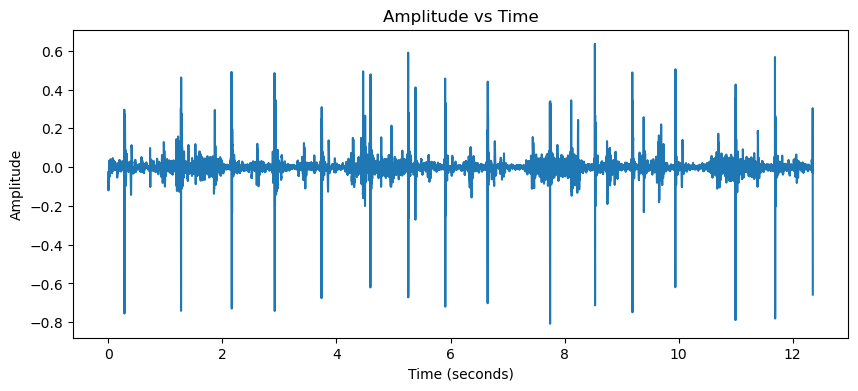

ABNORMAL


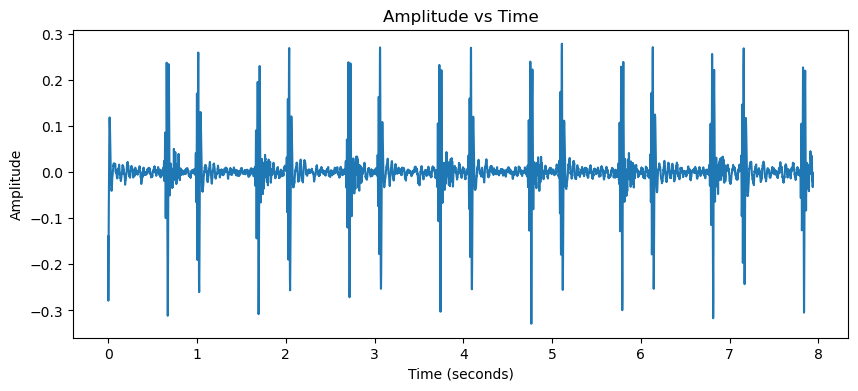

In [99]:
load_normal = load_audio(normal_path)
load_abnormal = load_audio(abnormal_path)
print("NORMAL")
plot_audio_waveform(load_normal,1000)
print("ABNORMAL")
plot_audio_waveform(load_abnormal,1000)

In [103]:
# Standardizing the input dimensions
fixed_length = 12000

# Function to pad or truncate audio data arrays to the fixed length
def preprocess_audio(audio_data):
    if len(audio_data) < fixed_length:
        # If the array is shorter than the fixed length, pad it with zeros
        padded_audio_data = np.pad(audio_data, (0, fixed_length - len(audio_data)), 'constant')
        return padded_audio_data
    elif len(audio_data) > fixed_length:
        # If the array is longer than the fixed length, truncate it
        truncated_audio_data = audio_data[:fixed_length]
        return truncated_audio_data
    else:
        # If the array is already of the fixed length, return it unchanged
        return audio_data

In [102]:


# Create a list to store dataset entries (audio data and labels)
dataset = []

#new sample rate
new_sample_rate = 1000
sample_rate = 8000


# Assign labels for normal heartbeats (label = 0)
for filename in os.listdir(normal_dir):
    file_path = os.path.join(normal_dir, filename)
    audio_data = load_audio(file_path)# Load audio data
    audio_data = preprocess_audio(audio_data) # standardizing the input data
    dataset.append((audio_data, 0))  # Append (audio data, label) tuple to dataset

# Assign labels for abnormal heartbeats (label = 1)
for filename in os.listdir(abnormal_dir):
    file_path = os.path.join(abnormal_dir, filename)
    audio_data = load_audio(file_path)  # Load audio data
    audio_data = preprocess_audio(audio_data) # standardizing the input data
    dataset.append((audio_data, 1))  # Append (audio data, label) tuple to dataset

# Shuffle the dataset
random.shuffle(dataset)

# Now, the dataset contains audio data along with their corresponding labels

In [57]:
def segment_dataset(dataset):
    segmented_dataset = []

    for audio_data, label in dataset:
        # Determine segment size
        segment_size = len(audio_data) // 4

        # Divide the audio data into segments
        segmented_arrays = [audio_data[i*segment_size:(i+1)*segment_size] for i in range(4)]

        # Append each segment along with its label to the segmented dataset
        for segment in segmented_arrays:
            segmented_dataset.append((segment, label))

    return segmented_dataset

dataset = segment_dataset(dataset)

In [58]:
print(f"The size of dataset we have: {len(dataset)}")

The size of dataset we have: 1672


In [59]:
def extract_cwt_features(audio_data, scales=np.arange(1, 128)):
    # Perform Continuous Wavelet Transform (CWT) using pywt
    cwt_data, _ = pywt.cwt(audio_data, scales, 'morl')

    # Take absolute values of CWT coefficients as features
    cwt_features = np.abs(cwt_data)

    return cwt_features

temp = extract_cwt_features(dataset[0][0])
temp.shape

(127, 3000)

In [60]:
def plot_cwt_scalogram(audio_data, sampling_rate, scales=np.arange(1,128)):
    # scaler = StandardScaler()
    # Calculate the CWT coefficients
    coeffs, _ = pywt.cwt(audio_data, scales, 'morl')
    # coeffs = scaler.fit_transform(coeffs)
    print(f"The shape of cwt extract: {coeffs.shape}")

    # Calculate time axis
    time = np.arange(0, len(audio_data)) / sampling_rate

    # Plot scalogram
    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(coeffs), extent=[0, len(audio_data), scales[-1], scales[0]],
               aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Scale')
    plt.title('Scalogram of Continuous Wavelet Transform')
    plt.show()


NORMAL
The shape of cwt extract: (127, 12351)


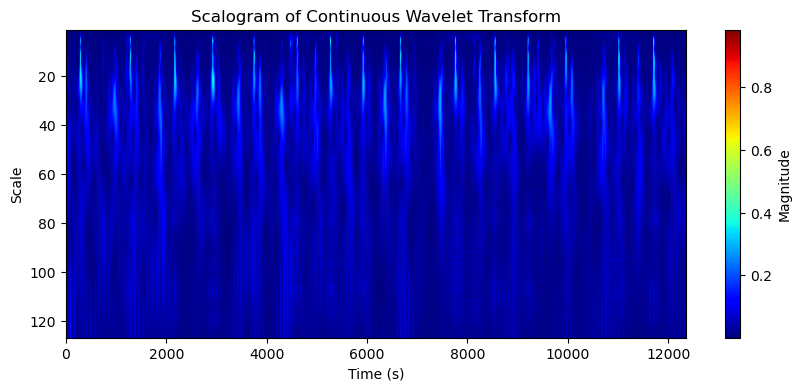

ABNORMAL
The shape of cwt extract: (127, 7936)


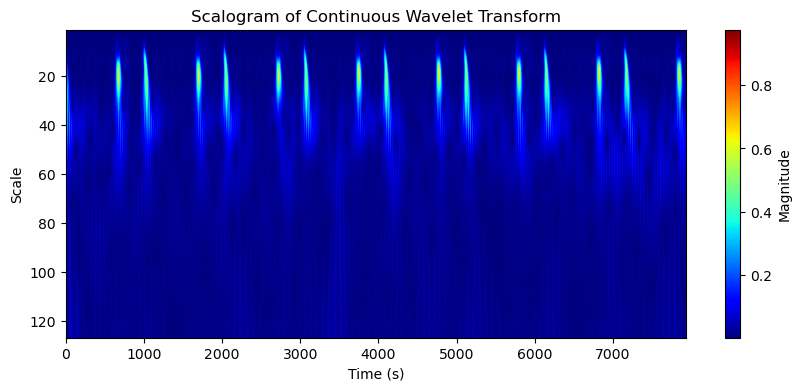

In [61]:
print("NORMAL")
plot_cwt_scalogram(load_normal,1000)
print("ABNORMAL")
plot_cwt_scalogram(load_abnormal,1000)

In [62]:
#spillting the dataset

# Split the dataset into features (audio data) and labels
X = [entry[0] for entry in dataset]  # Features (audio data)
y = [entry[1] for entry in dataset]  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
def extract_cwt_features_from_audio_dataset(audio_dataset, sample_rate, scales=np.arange(1, 128)):
  cwt_features_dataset = []

  for audio_data in audio_dataset:
      # Compute CWT features for each audio sample
      cwt_data, _ = pywt.cwt(audio_data, scales, 'morl')

      # Take absolute values of CWT coefficients as features
      cwt_features = np.abs(cwt_data)

      pca = PCA(n_components=100) # Assuming you want to reduce to 100 dimensions

      # Fit and transform the data matrix using PCA
      reduced_data = pca.fit_transform(cwt_features)

      # Append CWT features to the dataset
      cwt_features_dataset.append(reduced_data)

  return cwt_features_dataset

In [64]:
X_train_extracted = extract_cwt_features_from_audio_dataset(X_train,1000)
X_test_extracted = extract_cwt_features_from_audio_dataset(X_test,1000)

C:\Users\nehit\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
C:\Users\nehit\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
C:\Users\nehit\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
C:\Users\nehit\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
C:\Users\nehit\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / 

In [65]:
Xtrain = np.array(X_train_extracted)
Xtest = np.array(X_test_extracted)
ytrain = np.array(y_train)
ytest = np.array(y_test)

Xtrain.shape , ytrain.shape, Xtest.shape, ytest.shape

((1337, 127, 100), (1337,), (335, 127, 100), (335,))

In [66]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix with default labels '0' and '1'
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

#MODEL 1

In [67]:
model1 = Sequential()

# Add convolutional layers and pooling layers
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(127, 100, 1)))
model1.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model1.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model1.add(AveragePooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dropout(0.5))

# Add dense layers
model1.add(Dense(8, activation='relu'))
model1.add(Dense(2, activation='softmax'))

adam = Adam(learning_rate=0.001)
# Compile the model with sparse_categorical_crossentropy
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 125, 98, 64)       640       
                                                                 
 average_pooling2d_3 (Avera  (None, 62, 49, 64)        0         
 gePooling2D)                                                    
                                                                 
 dropout_3 (Dropout)         (None, 62, 49, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 47, 32)        18464     
                                                                 
 average_pooling2d_4 (Avera  (None, 30, 23, 32)        0         
 gePooling2D)                                                    
                                                                 
 dropout_4 (Dropout)         (None, 30, 23, 32)       

In [68]:
model1_accuracies = []
for i in range(3):
     print("step: ",i+1)
     model1.fit(Xtrain, ytrain, epochs=15, batch_size=32)
     test_loss_m1, test_accuracy_m1 = model1.evaluate(Xtest, ytest, verbose=2)
     model1_accuracies.append(test_accuracy_m1)

mean_test_accuracy_m1 = np.mean(model1_accuracies)
print("Mean test accuracy Model 1:", mean_test_accuracy_m1)

step:  1
Epoch 1/15
42/42 [==============================] - 13s 230ms/step - loss: 0.6911 - accuracy: 0.5206
Epoch 2/15
42/42 [==============================] - 10s 229ms/step - loss: 0.6878 - accuracy: 0.5460
Epoch 3/15
42/42 [==============================] - 9s 221ms/step - loss: 0.6831 - accuracy: 0.5430
Epoch 4/15
42/42 [==============================] - 10s 229ms/step - loss: 0.6788 - accuracy: 0.5445
Epoch 5/15
42/42 [==============================] - 10s 230ms/step - loss: 0.6820 - accuracy: 0.5482
Epoch 6/15
42/42 [==============================] - 10s 231ms/step - loss: 0.6755 - accuracy: 0.5497
Epoch 7/15
42/42 [==============================] - 10s 234ms/step - loss: 0.6766 - accuracy: 0.5527
Epoch 8/15
42/42 [==============================] - 9s 221ms/step - loss: 0.6690 - accuracy: 0.5475
Epoch 9/15
42/42 [==============================] - 9s 219ms/step - loss: 0.6743 - accuracy: 0.5535
Epoch 10/15
42/42 [==============================] - 9s 222ms/step - loss: 0.6758 - a

In [69]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Assuming you have training and validation data (X_train, y_train, X_val, y_val)
history = model1.fit(Xtrain, ytrain, epochs=20, batch_size=32, validation_data=(Xtest, ytest), callbacks=[early_stopping, checkpoint])

# After training, load the best model weights
model1.load_weights('best_model_weights.h5')

# Evaluate the model
loss, accuracy = model1.evaluate(Xtest, ytest)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.5924
Epoch 1: val_accuracy improved from -inf to 0.65373, saving model to best_model_weights.h5


C:\Users\nehit\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 11s 267ms/step - loss: 0.6363 - accuracy: 0.5924 - val_loss: 0.6548 - val_accuracy: 0.6537
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.5894
Epoch 2: val_accuracy did not improve from 0.65373
42/42 [==============================] - 11s 255ms/step - loss: 0.6438 - accuracy: 0.5894 - val_loss: 0.6589 - val_accuracy: 0.5343
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.5871
Epoch 3: val_accuracy did not improve from 0.65373
42/42 [==============================] - 11s 258ms/step - loss: 0.6411 - accuracy: 0.5871 - val_loss: 0.6529 - val_accuracy: 0.6358
Epoch 4/20
42/42 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6096
Epoch 4: val_accuracy did not improve from 0.65373
42/42 [==============================] - 10s 247ms/step - loss: 0.6385 - accuracy: 0.6096 - val_loss: 0.6510 - val_accuracy: 0.6179
Epoch 5/20
42/42 [===================

In [70]:
model1.load_weights('best_model_weights.h5')

In [71]:
# Evaluate the model on the test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = model1.predict(Xtest)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate evaluation metrics
accuracy = accuracy_score(ytest, y_pred_classes)
precision = precision_score(ytest, y_pred_classes, average='weighted')
recall = recall_score(ytest, y_pred_classes, average='weighted')
f1 = f1_score(ytest, y_pred_classes, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")



11/11 [==============================] - 1s 44ms/step
Accuracy: 0.6537313432835821
Precision: 0.652074790880761
Recall: 0.6537313432835821
F1-score: 0.6523173605655931


In [72]:
from sklearn.metrics import confusion_matrix

def calculate_sensitivity_specificity(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    TP = cm[1, 1]  # True Positives
    TN = cm[0, 0]  # True Negatives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives

    # Calculate Sensitivity (True Positive Rate, TPR)
    sensitivity = TP / (TP + FN)

    # Calculate Specificity (True Negative Rate, TNR)
    specificity = TN / (TN + FP)

    return sensitivity, specificity

# Assuming y_true contains the true binary labels (0 and 1) and y_pred contains the predicted labels
sensitivity, specificity = calculate_sensitivity_specificity(ytest, y_pred_classes)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity}")
print(f"Specificity (True Negative Rate, TNR): {specificity}")


Sensitivity (True Positive Rate, TPR): 0.7135135135135136
Specificity (True Negative Rate, TNR): 0.58


|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |    87    |    63    |
|    1     |    53    |   132    |
----------------------------------------


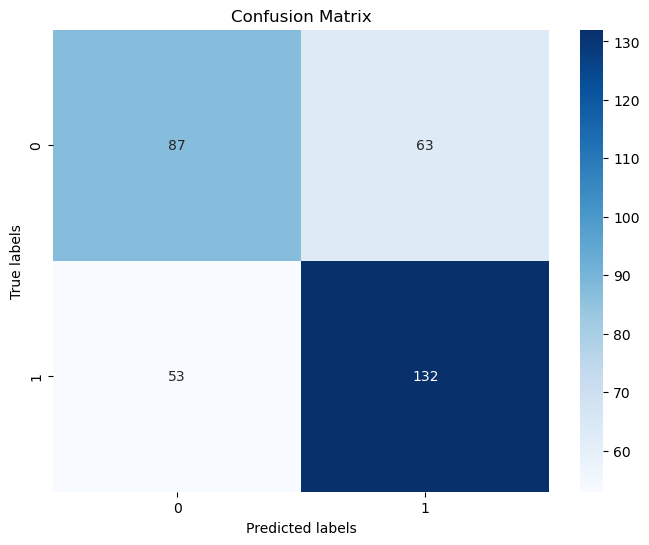

In [82]:
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    if labels is None:
        labels = sorted(set(y_true).union(y_pred))

    header = "|{:^10}|".format("True \\ Predicted")
    header += "|".join(["{:^10}".format(label) for label in labels]) + "|"
    print(header)

    print("-" * len(header))

    for i, row_label in enumerate(labels):
        row = "|{:^10}|".format(row_label)
        row += "|".join(["{:^10}".format(cm[i, j]) for j in range(len(labels))]) + "|"
        print(row)

    print("-" * len(header))

display_confusion_matrix(ytest, y_pred_classes)
plot_confusion_matrix(ytest,y_pred_classes)


#MODEL 2

In [77]:
X_train_flattened = np.array([feature.flatten() for feature in X_train_extracted])
X_test_flattened = np.array([feature.flatten() for feature in X_test_extracted])
X_train_flattened.shape,X_test_flattened.shape

((1337, 12700), (335, 12700))

In [78]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
random_forest.fit(X_train_flattened, ytrain)

# Make predictions on the test set
y_pred_1 = random_forest.predict(X_test_flattened)

# Calculate accuracy
accuracy = accuracy_score(ytest, y_pred_1)
precision = precision_score(ytest, y_pred_1, average='weighted')
recall = recall_score(ytest, y_pred_1, average='weighted')
f1 = f1_score(ytest, y_pred_1, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.573134328358209
Precision: 0.5655104947471202
Recall: 0.573134328358209
F1-score: 0.5596455967400165


In [83]:
display_confusion_matrix(ytest, y_pred_1)

|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |    57    |    93    |
|    1     |    50    |   135    |
----------------------------------------


In [84]:
# Assuming y_true contains the true binary labels (0 and 1) and y_pred contains the predicted labels
sensitivity_1, specificity_1 = calculate_sensitivity_specificity(ytest, y_pred_1)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity_1}")
print(f"Specificity (True Negative Rate, TNR): {specificity_1}")

Sensitivity (True Positive Rate, TPR): 0.7297297297297297
Specificity (True Negative Rate, TNR): 0.38


#MODEL 3

In [87]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam



# Load pre-trained ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(127, 100, 3))

# Freeze ResNet layers so they won't be trained
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom layers for classification on top of ResNet50
x = Flatten()(resnet_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 'num_classes' is the number of output classes

# Create the model
model_4 = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model_4.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now you can train or evaluate the model using your data



In [88]:
X_train_reduced_np = np.array(X_train_extracted)
X_test_reduced_np = np.array(X_test_extracted)

# Reshape the PCA-reduced features to match ResNet input shape (127x127x1)
X_train_reshaped = X_train_reduced_np.reshape(X_train_reduced_np.shape[0], 127, 100, 1)
X_test_reshaped = X_test_reduced_np.reshape(X_test_reduced_np.shape[0], 127, 100, 1)

# Replicate the single channel to create a pseudo-RGB image
X_train_rgb = np.concatenate([X_train_reshaped, X_train_reshaped, X_train_reshaped], axis=-1)
X_test_rgb = np.concatenate([X_test_reshaped, X_test_reshaped, X_test_reshaped], axis=-1)


In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have X_train, y_train, X_test, y_test after data preprocessing and splitting

# Train your modified ResNet-50 V2 model
history = model_4.fit(X_train_rgb, ytrain, epochs=13, batch_size=32,validation_data=(X_test_rgb, ytest))

Epoch 1/13
42/42 [==============================] - 42s 822ms/step - loss: 2.9671 - accuracy: 0.5183 - val_loss: 0.9451 - val_accuracy: 0.5522
Epoch 2/13
42/42 [==============================] - 33s 786ms/step - loss: 0.7267 - accuracy: 0.5625 - val_loss: 0.6781 - val_accuracy: 0.5821
Epoch 3/13
42/42 [==============================] - 34s 804ms/step - loss: 0.6875 - accuracy: 0.5654 - val_loss: 0.6847 - val_accuracy: 0.6000
Epoch 4/13
42/42 [==============================] - 33s 785ms/step - loss: 0.6515 - accuracy: 0.5886 - val_loss: 0.6959 - val_accuracy: 0.5493
Epoch 5/13
42/42 [==============================] - 33s 798ms/step - loss: 0.6562 - accuracy: 0.5976 - val_loss: 0.7033 - val_accuracy: 0.5194
Epoch 6/13
42/42 [==============================] - 33s 790ms/step - loss: 0.7492 - accuracy: 0.5639 - val_loss: 0.7564 - val_accuracy: 0.5134
Epoch 7/13
42/42 [==============================] - 33s 779ms/step - loss: 0.7009 - accuracy: 0.5767 - val_loss: 0.6721 - val_accuracy: 0.6149

In [34]:
y_pred_2 = model_4.predict(X_test_rgb)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)  # Convert probabilities to class labels

# Calculate evaluation metrics
accuracy = accuracy_score(ytest, y_pred_classes_2)
precision = precision_score(ytest, y_pred_classes_2, average='weighted')
recall = recall_score(ytest, y_pred_classes_2, average='weighted')
f1 = f1_score(ytest, y_pred_classes_2, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

11/11 [==============================] - 9s 547ms/step
Accuracy: 0.6029850746268657
Precision: 0.6295732474937124
Recall: 0.6029850746268657
F1-score: 0.5291781909116685


In [35]:
display_confusion_matrix(ytest, y_pred_classes_2)

|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |    25    |   121    |
|    1     |    12    |   177    |
----------------------------------------


In [36]:
# Assuming y_true contains the true binary labels (0 and 1) and y_pred contains the predicted labels
sensitivity_2, specificity_2 = calculate_sensitivity_specificity(ytest, y_pred_classes_2)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity_2}")
print(f"Specificity (True Negative Rate, TNR): {specificity_2}")

Sensitivity (True Positive Rate, TPR): 0.9365079365079365
Specificity (True Negative Rate, TNR): 0.17123287671232876


#MODEL 4(Model 1 features extracted and a random classifier)

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Extract features from the second last fully connected layer
feature_extractor_m1 = tf.keras.Model(inputs=model1.inputs, outputs=model1.layers[-2].output)

# Predict the features for train and test data
train_features_m1 = feature_extractor_m1.predict(Xtrain)
test_features_m1 = feature_extractor_m1.predict(Xtest)

# Model features using Random Forest classifier
rf_classifier_m1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_m1.fit(train_features_m1, ytrain)

# Predict using the Random Forest classifier
predictions_m1 = rf_classifier_m1.predict(test_features_m1)

# Calculate accuracy
accuracy_m1 = accuracy_score(ytest, predictions_m1)
print("Accuracy of Random Forest classifier on extracted features model 1:", accuracy_m1)

11/11 [==============================] - 1s 45ms/step
Accuracy of Random Forest classifier on extracted features model 1: 0.5791044776119403
